In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor

In [2]:
#
# load data and inspect
#
df = pd.read_csv('../Datasets/austin_weather.csv')

In [3]:
df = df.loc[:, ['Date', 'TempAvgF']]

In [4]:
#
# add time-based columns
#
df.loc[:, 'Year'] = df.loc[:, 'Date'].str.slice(0, 4).astype('int')
df.loc[:, 'Month'] = df.loc[:, 'Date'].str.slice(5, 7).astype('int')
df.loc[:, 'Day'] = df.loc[:, 'Date'].str.slice(8, 10).astype('int')

In [5]:
#
# set a 20 day window then use that to smooth 
# temperature in a new column
window = 20
df['20_d_mov_avg'] = df.TempAvgF.rolling(window).mean()

In [6]:
#
# now let's slice exactly one year on the
# calendar start and end dates
# we see from the previous output that 
# 2014 is the first year with complete data, 
# however it will still have NaN values for 
# the moving average, so we'll use 2015
#
df_one_year = df.loc[df.Year == 2015, :].reset_index()
df_one_year['Day_of_Year'] = df_one_year.index + 1
print(df_one_year.head())
print(df_one_year.tail())

   index        Date  TempAvgF  Year  Month  Day  20_d_mov_avg  Day_of_Year
0    376  2015-01-01        37  2015      1    1         52.70            1
1    377  2015-01-02        41  2015      1    2         51.50            2
2    378  2015-01-03        51  2015      1    3         50.65            3
3    379  2015-01-04        43  2015      1    4         49.65            4
4    380  2015-01-05        41  2015      1    5         48.95            5
     index        Date  TempAvgF  Year  Month  Day  20_d_mov_avg  Day_of_Year
360    736  2015-12-27        55  2015     12   27         61.10          361
361    737  2015-12-28        41  2015     12   28         60.20          362
362    738  2015-12-29        43  2015     12   29         59.25          363
363    739  2015-12-30        49  2015     12   30         58.45          364
364    740  2015-12-31        46  2015     12   31         57.45          365


In [7]:
#
# scale the data
#
X_min = df_one_year.Day_of_Year.min()
X_range = df_one_year.Day_of_Year.max() - df_one_year.Day_of_Year.min()
Y_min = df_one_year.TempAvgF.min()
Y_range = df_one_year.TempAvgF.max() - df_one_year.TempAvgF.min()
scale_X = (df_one_year.Day_of_Year - X_min) / X_range
#
train_X = scale_X.ravel()
train_Y = ((df_one_year.TempAvgF - Y_min) / Y_range).ravel()

In [8]:
#
# create the model object
#
np.random.seed(42)
model = SGDRegressor(
    loss = 'squared_loss',
    max_iter = 100,
    learning_rate = 'constant',
    eta0 = 0.0005,
    tol = 0.00009,
    penalty = 'none')

In [9]:
#
# fit the model
#
model.fit(train_X.reshape((-1, 1)), train_Y)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=100,
             n_iter_no_change=5, penalty='none', power_t=0.25,
             random_state=None, shuffle=True, tol=9e-05,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
Beta0 = (Y_min + Y_range * model.intercept_[0] - 
        Y_range * model.coef_[0] * X_min / X_range)
Beta1 = Y_range * model.coef_[0] / X_range
print(Beta0)
print(Beta1)

61.45512325422412
0.04533603293003107


In [11]:
#
# generate predictions
#
pred_X = df_one_year['Day_of_Year']
pred_Y = model.predict(train_X.reshape((-1, 1)))

In [12]:
#
# calcualte the r squared value
#
r2 = r2_score(train_Y, pred_Y)
print('r squared = ', r2)

r squared =  0.09462157379706759


In [13]:
#
# scale predictions back to real values
#
pred_Y = (pred_Y * Y_range) + Y_min

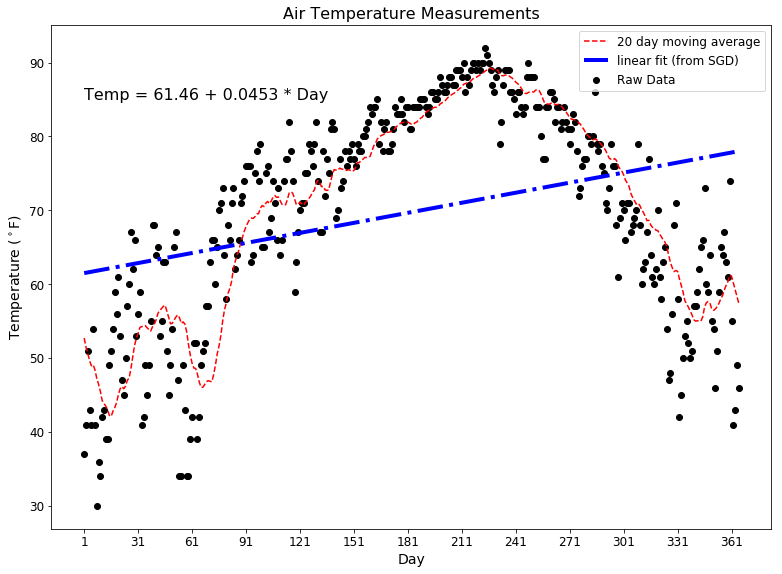

In [14]:
fig = plt.figure(figsize = (10, 7))
ax = fig.add_axes([1, 1, 1, 1])
#
# Raw data
#
ax.scatter(df_one_year.Day_of_Year, 
           df_one_year.TempAvgF, 
           label = 'Raw Data', c = 'k')
#
# Moving averages
#
ax.plot(df_one_year.Day_of_Year,
        df_one_year['20_d_mov_avg'], 
        c = 'r', 
        linestyle = '--', 
        label = f'{window} day moving average')
#
# Regression predictions
#
ax.plot(pred_X, pred_Y,
        c = "blue",
        linestyle = '-.',
        linewidth = 4,
        label = 'linear fit (from SGD)')
#
# put the model on the plot
#
ax.text(1, 85,
        'Temp = ' + 
        str(round(Beta0, 2)) +
        ' + ' +
        str(round(Beta1, 4)) +
        ' * Day',
        fontsize = 16)
#
ax.set_title('Air Temperature Measurements',
             fontsize = 16)
ax.set_xlabel('Day', 
              fontsize = 14)
ax.set_ylabel('Temperature ($^\circ$F)', 
              fontsize = 14)
ax.set_xticks(range(df_one_year.Day_of_Year.min(), 
                    df_one_year.Day_of_Year.max(), 
                    30))
ax.tick_params(labelsize = 12)
ax.legend(fontsize = 12)
plt.show()